### PSF Investigation

In [1]:
# Imports
from astropy.table import Table
import lsst.daf.butler as dafButler
import glob
import lsst.afw.table as afwTable
import matplotlib as mpl
import matplotlib.pyplot as plt
from modelling_research.plotting import plotjoint_running_percentiles
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Config
hsc = False
overwrite = True
gen2to3 = True
midfix = '_gen2to3' if gen2to3 else ''
savepre = (f'/project/dtaranu/{"cosmos/hsc/" if hsc else "dc2_gen3"}'
           f'/w_2021_{"26" if hsc else "24"}{midfix}_coaddpsf/')
savepost = '.parq'
bands = ['g', 'r', 'i']
if hsc:
    butler = dafButler.Butler('/repo/main', collections='HSC/runs/RC2/w_2021_26/DM-30867')
    tract = 9813
    n_patches = 81
    scale_pix = 0.168
else:
    butler = dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2021_24/DM-30730')
    tract = 3828
    n_patches = 49
    scale_pix = 0.2
patches = list(range(n_patches))

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

In [4]:
# Take a sourceCatalog and turn it into a condensed parquet table
def make_summary(butler, type_cat=None, **kwargs):
    if type_cat is None:
        type_cat = 'deepCoadd_meas'
    try:
        src = butler.get(type_cat, **kwargs)
    except Exception as e:
        print(f'Failed to butler.get({type_cat}, {kwargs}) due to {e}')
        return None

    mask = np.logical_and.reduce((
        src.get('calib_psf_used')==1,
        src.get('base_PixelFlags_flag_interpolated')==False,
        src.get('base_PixelFlags_flag_saturated')==False,
        src.get('base_PixelFlags_flag_inexact_psf')==False,
        src.get('base_PixelFlags_flag_clipped')==False
    ))
    if np.sum(mask)==0:
        print('No data')
        return None
    sIxxKey = src.schema.find('base_SdssShape_xx').key
    sIyyKey = src.schema.find('base_SdssShape_yy').key
    sIxyKey = src.schema.find('base_SdssShape_xy').key
    mIxxKey = src.schema.find('base_SdssShape_psf_xx').key
    mIyyKey = src.schema.find('base_SdssShape_psf_yy').key
    mIxyKey = src.schema.find('base_SdssShape_psf_xy').key
    fluxPsfKey = src.schema.find('base_PsfFlux_instFlux').key
    fluxPsfErrKey = src.schema.find('base_PsfFlux_instFluxErr').key
    fluxCmodelKey = src.schema.find('modelfit_CModel_instFlux').key
    fluxCmodelErrKey = src.schema.find('modelfit_CModel_instFluxErr').key
    stars = src[mask]
    starIxx = src.get(sIxxKey)[mask]
    starIxy = src.get(sIxyKey)[mask]
    starIyy = src.get(sIyyKey)[mask]
    modelIxx = src.get(mIxxKey)[mask]
    modelIxy = src.get(mIxyKey)[mask]
    modelIyy = src.get(mIyyKey)[mask]
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*scale_pix
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*scale_pix
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = src.get(fluxPsfKey)[mask]
    data['fluxPsfErr'] = src.get(fluxPsfErrKey)[mask]
    data['fluxCmodel'] = src.get(fluxCmodelKey)[mask]
    data['fluxCmodelErr'] = src.get(fluxCmodelErrKey)[mask]
    df = pd.DataFrame(data)
    return df

def make_table(band, tract, patches, **kwargs):
    data=[]
    for patch in patches:
        print(f'Making summary for band={band}, tract={tract}, patch={patch}')
        result = make_summary(band=band, tract=tract, patch=patch, **kwargs)
        if result is None:
            continue
        data.append(result)
    table = pd.concat(data)
    return table

In [5]:
# Read/write data
data = {}
for band in bands:
    desc = f'{tract}_{band}'
    savefile = f'{savepre}{desc}{savepost}'
    if overwrite or not os.path.exists(savefile):
        print(f'Generating {savefile} for band={band}, tract={tract}, patches={patches}')
        table = make_table(band, tract, patches, butler=butler)
        table.to_parquet(savefile)
        data[band] = table
    else:
        print(f'Reading {savefile}')
        data[band] = pd.read_parquet(savefile)

Generating /project/dtaranu/dc2_gen3/w_2021_24_gen2to3_coaddpsf/3828_g.parq for band=g, tract=3828, patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Making summary for band=g, tract=3828, patch=0
Making summary for band=g, tract=3828, patch=1
Making summary for band=g, tract=3828, patch=2
Making summary for band=g, tract=3828, patch=3
Making summary for band=g, tract=3828, patch=4
Making summary for band=g, tract=3828, patch=5
Making summary for band=g, tract=3828, patch=6
Making summary for band=g, tract=3828, patch=7
Making summary for band=g, tract=3828, patch=8
Making summary for band=g, tract=3828, patch=9
Making summary for band=g, tract=3828, patch=10
Making summary for band=g, tract=3828, patch=11
Making summary for band=g, tract=3828, patch=12
Making summary for band=g, tract=3828, patch=13
Making summary for band=g, tract=3828, patc

g Lanczos5 PSF model residuals (N=5736)


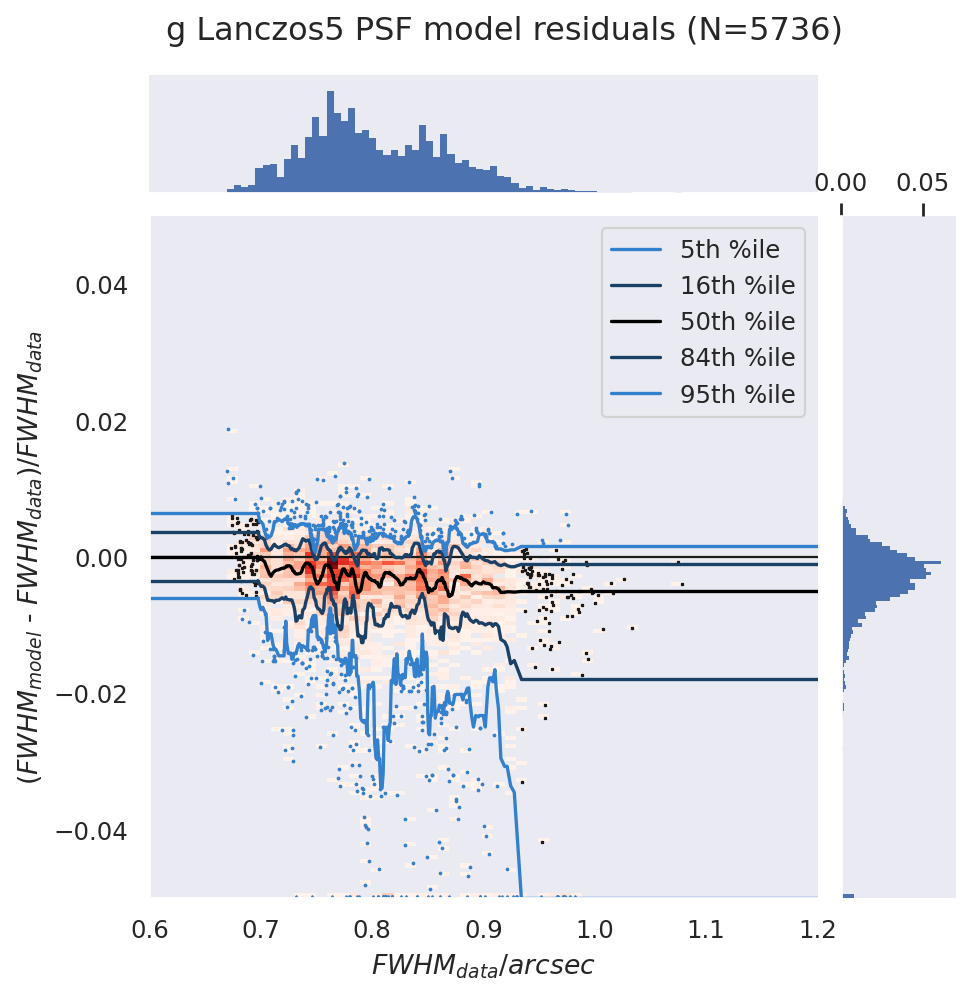

r Lanczos5 PSF model residuals (N=4971)


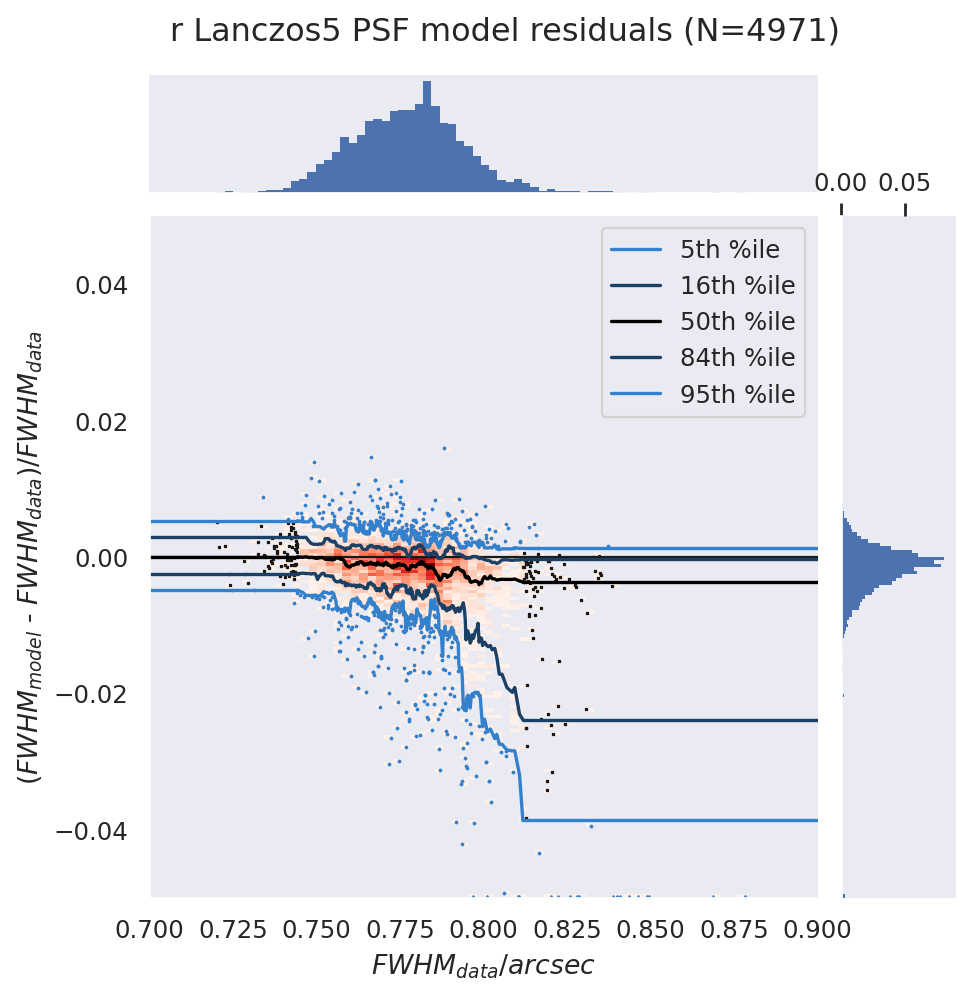

i Lanczos5 PSF model residuals (N=3426)


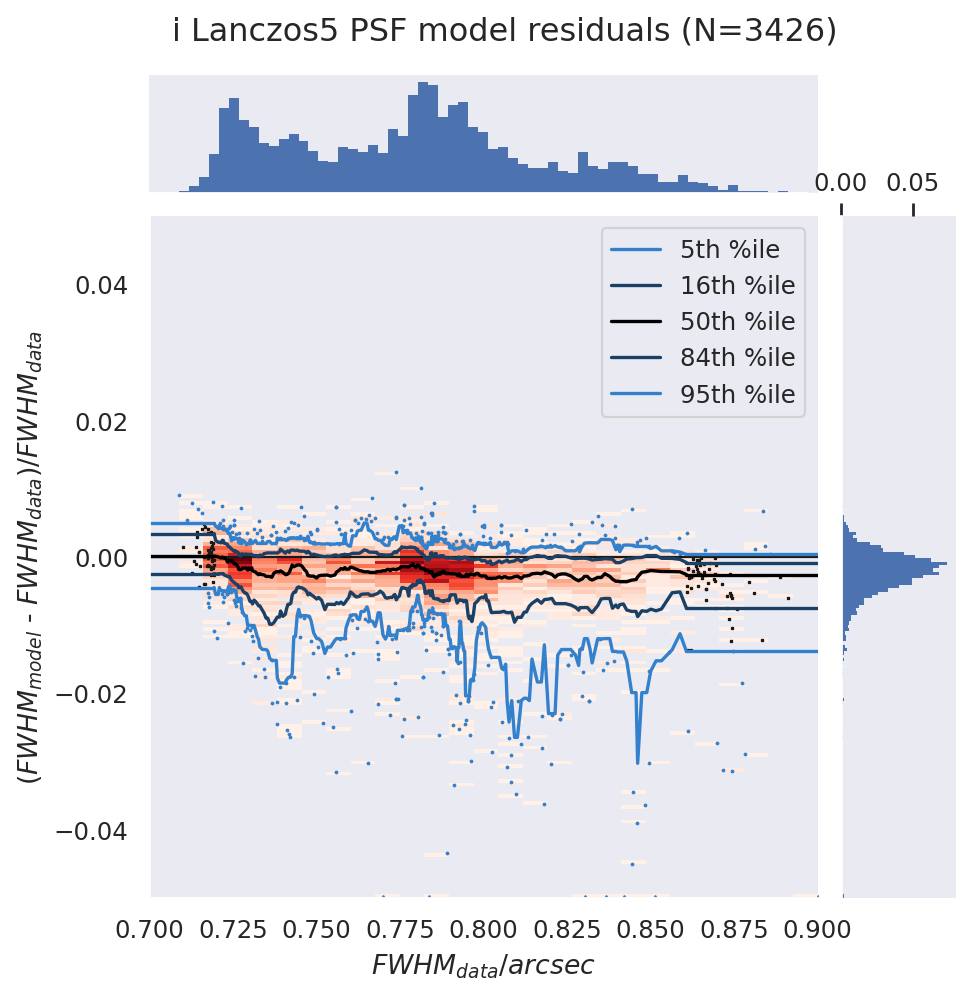

g Lanczos5, 0.670 <= FWHM <= 0.759, N=1433


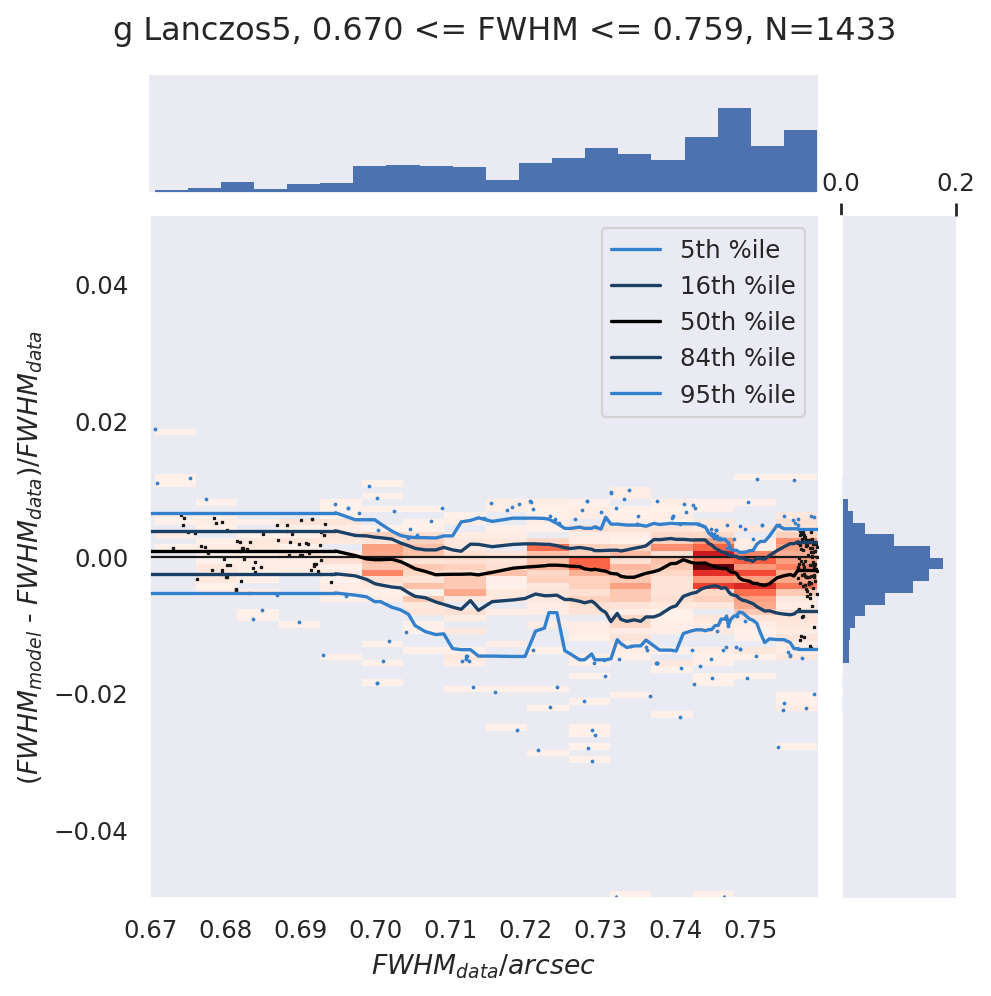

g Lanczos5, 0.759 <= FWHM <= 0.793, N=1433


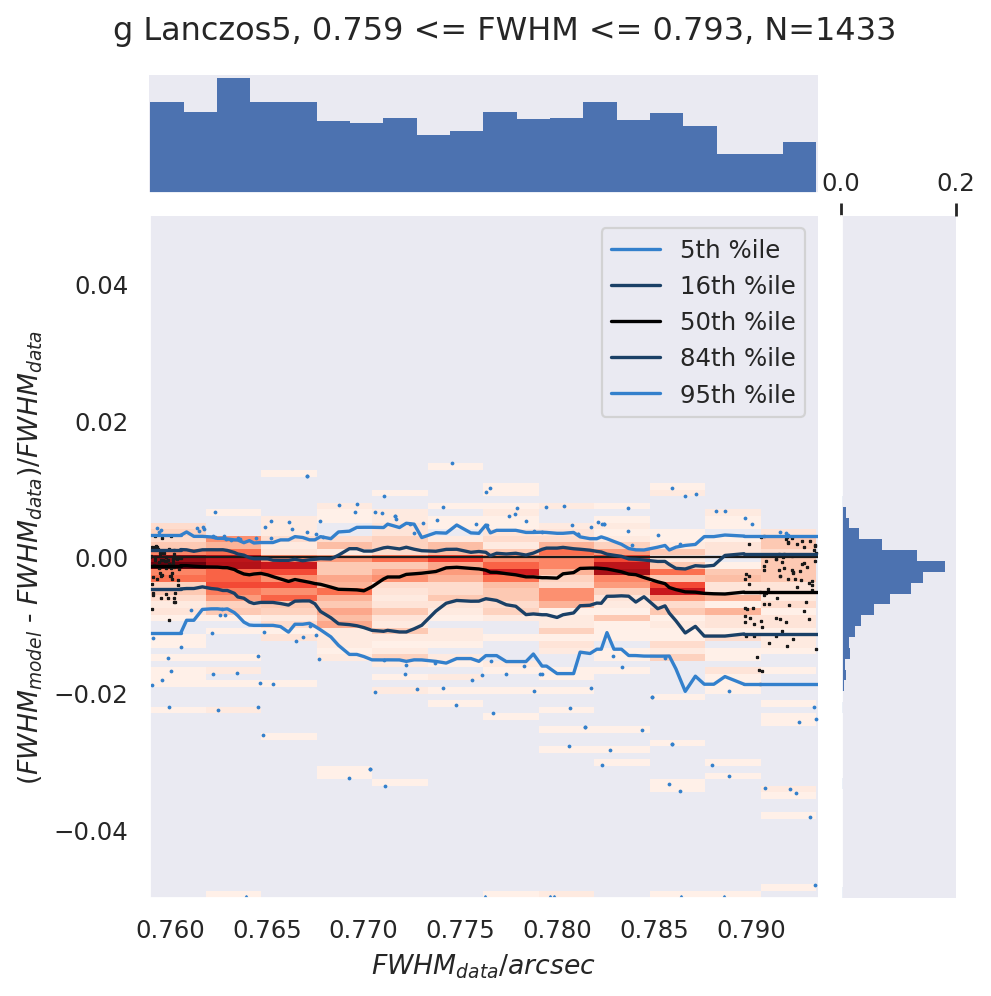

g Lanczos5, 0.793 <= FWHM <= 0.849, N=1432


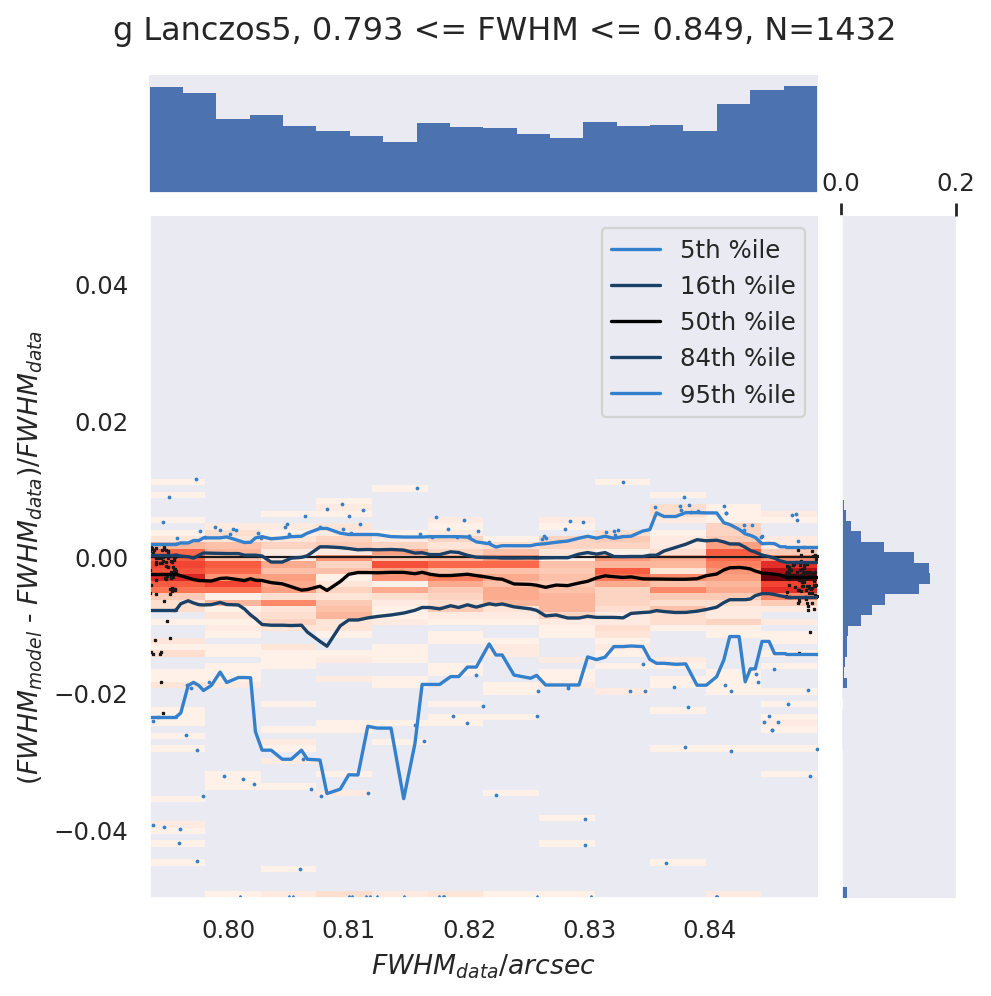

g Lanczos5, 0.849 <= FWHM <= 1.078, N=1433


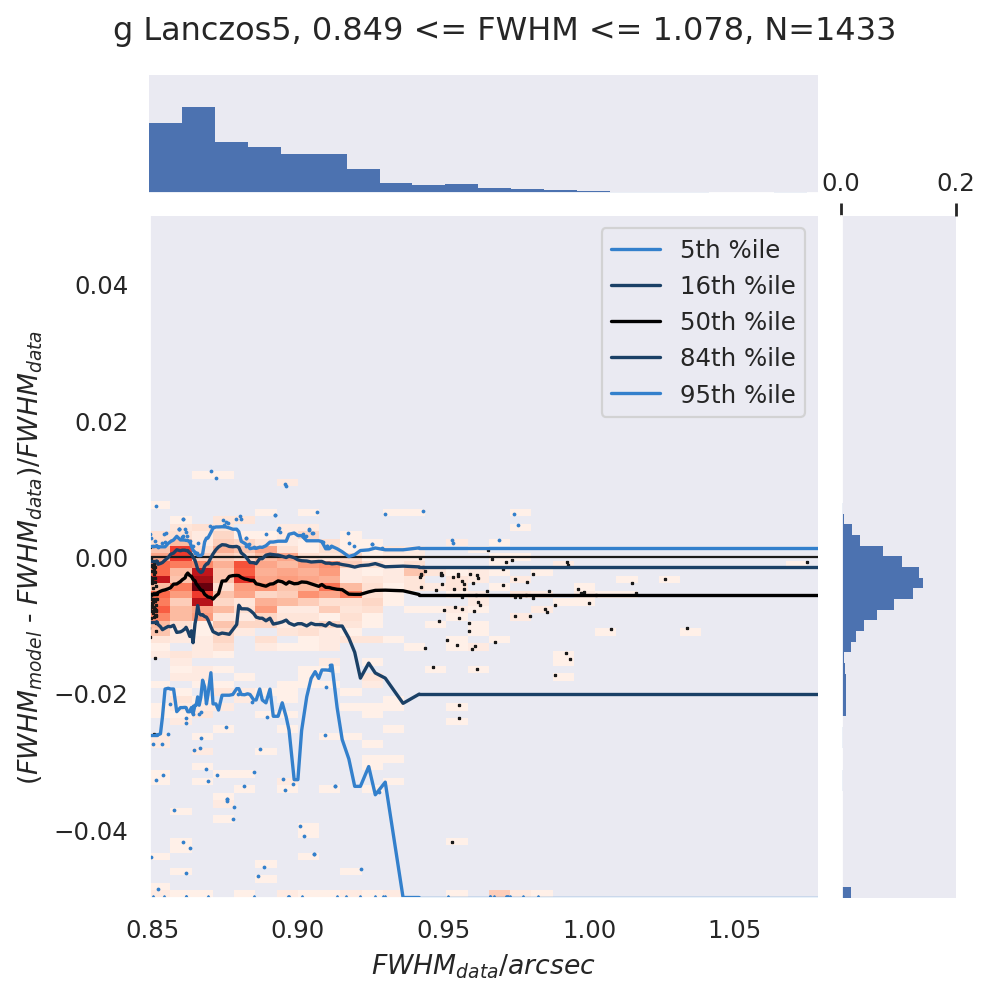

r Lanczos5, 0.720 <= FWHM <= 0.766, N=1241


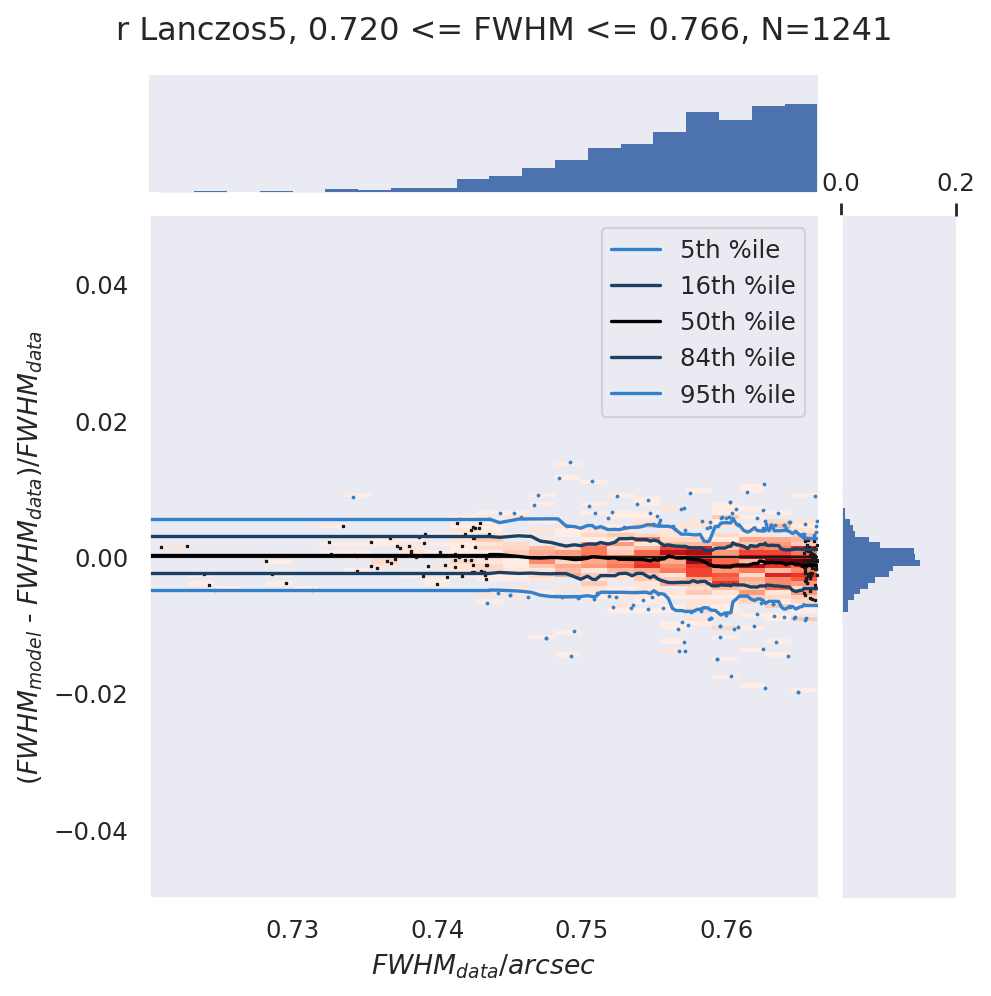

r Lanczos5, 0.766 <= FWHM <= 0.778, N=1241


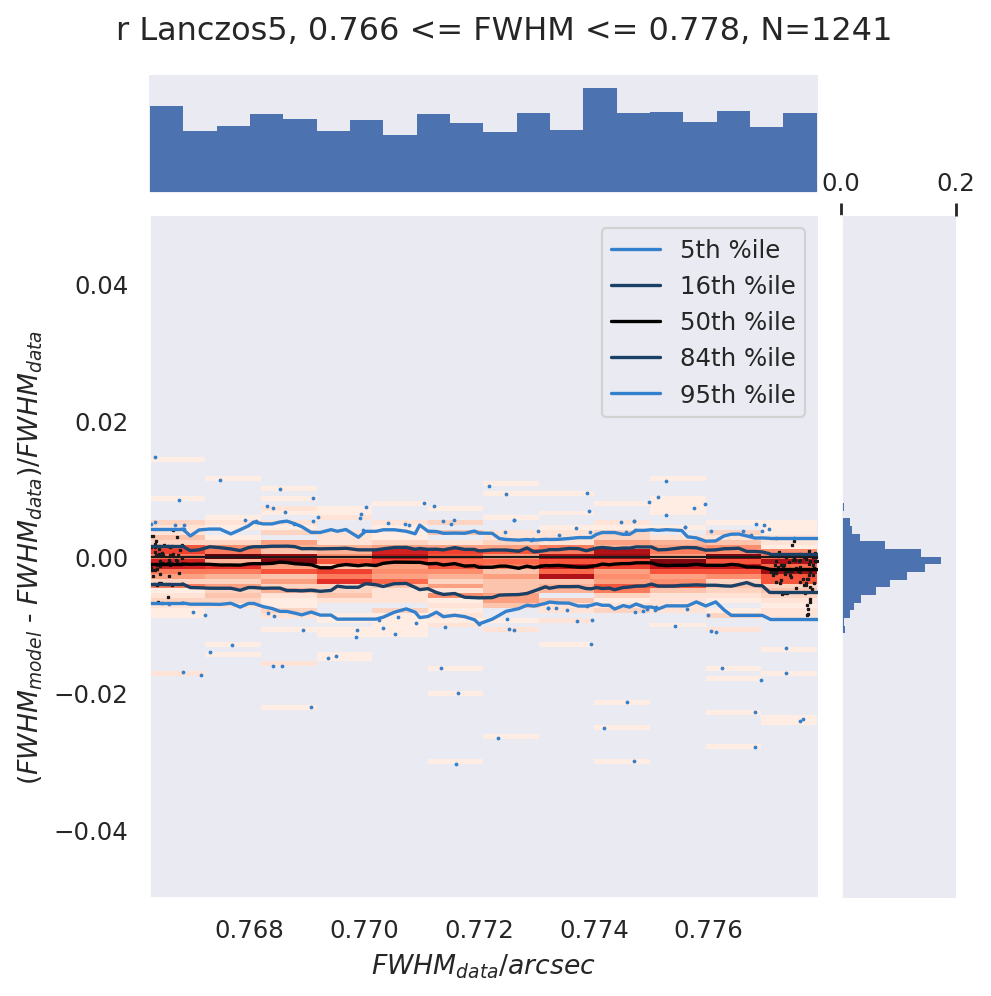

r Lanczos5, 0.778 <= FWHM <= 0.788, N=1242


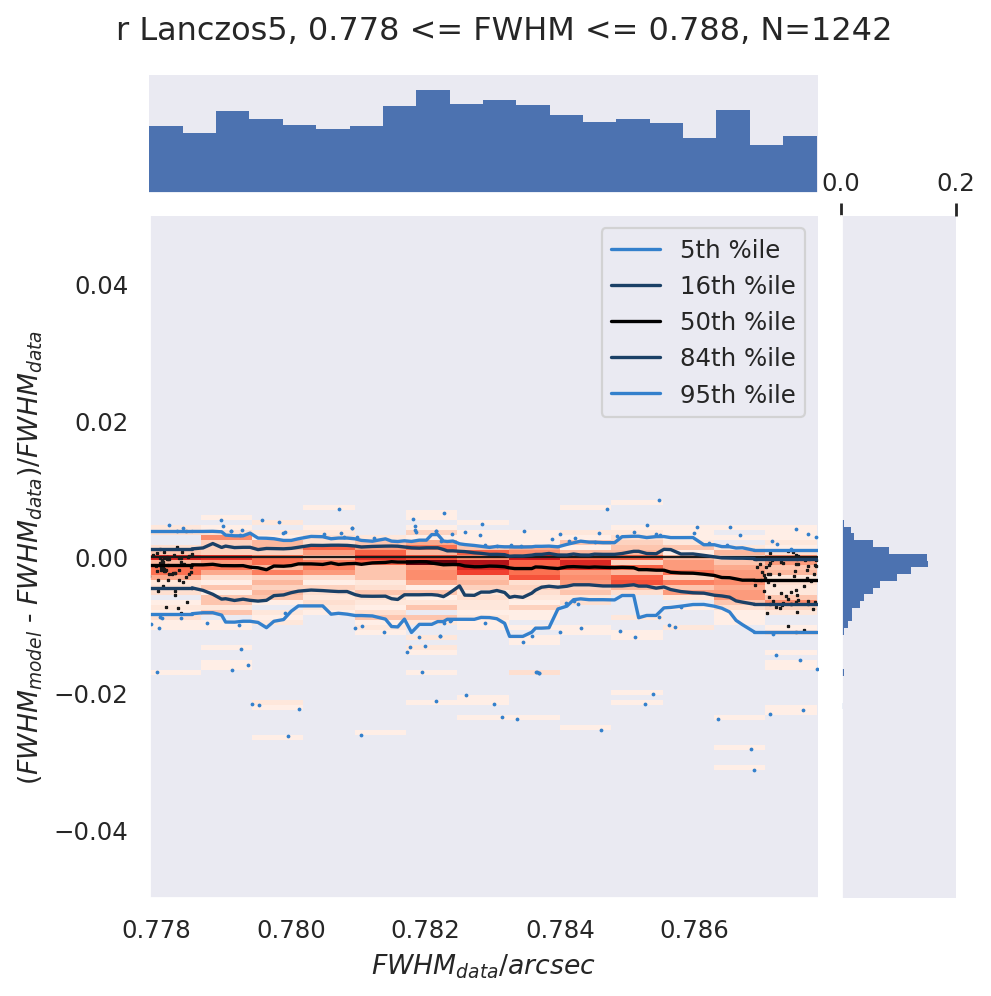

r Lanczos5, 0.788 <= FWHM <= 0.878, N=1241


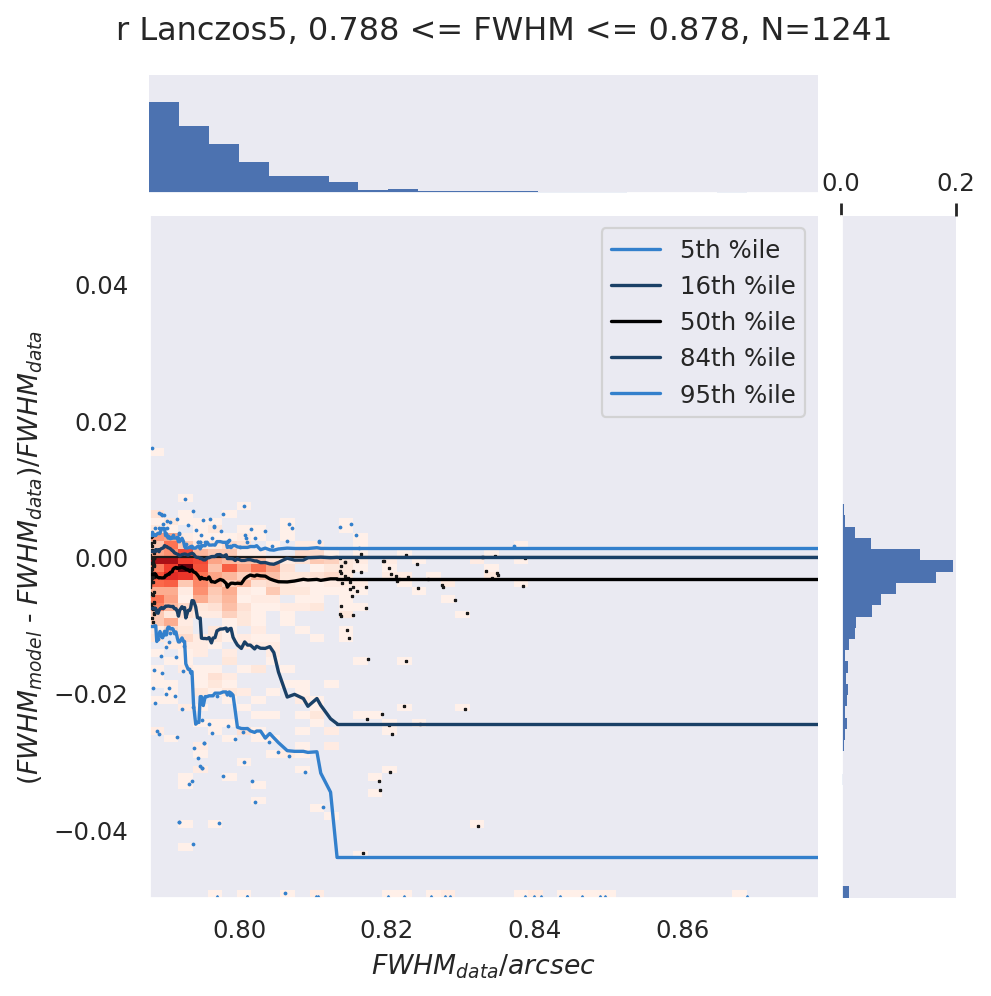

i Lanczos5, 0.709 <= FWHM <= 0.745, N=855


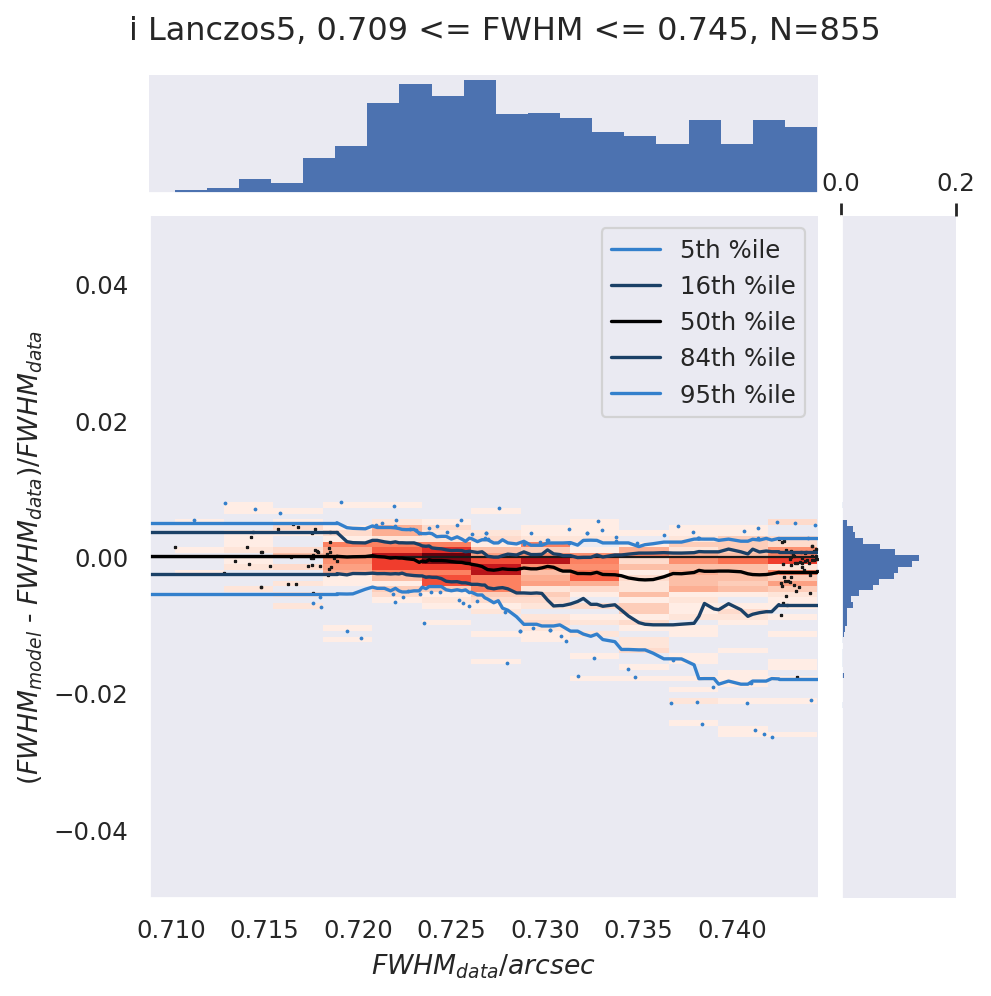

i Lanczos5, 0.745 <= FWHM <= 0.780, N=855


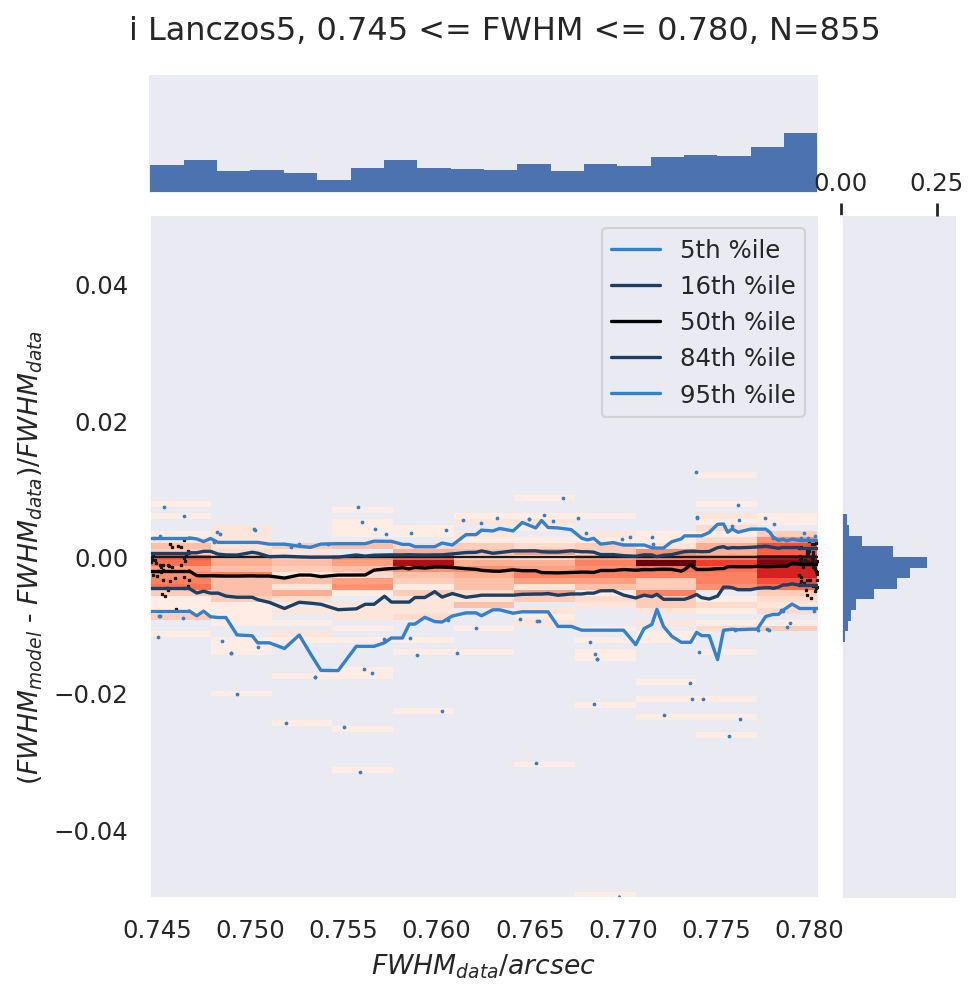

i Lanczos5, 0.780 <= FWHM <= 0.801, N=856


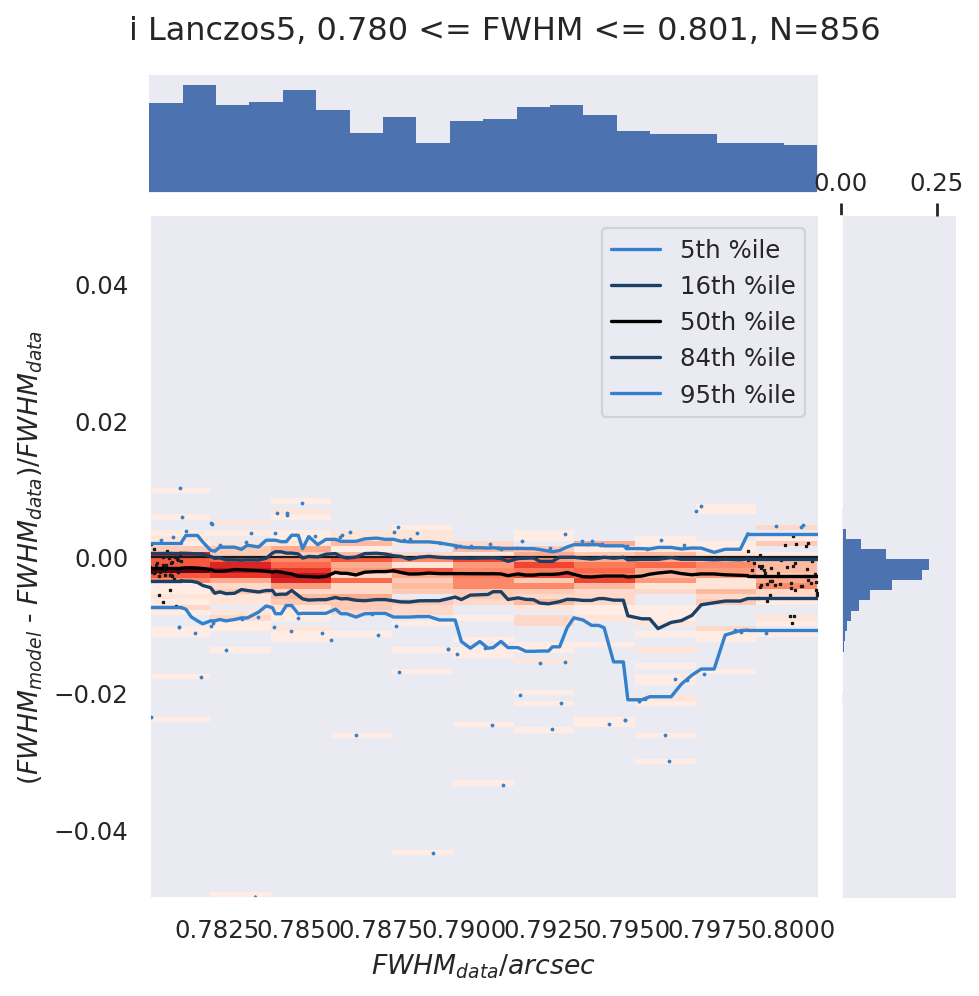

i Lanczos5, 0.801 <= FWHM <= 0.911, N=855


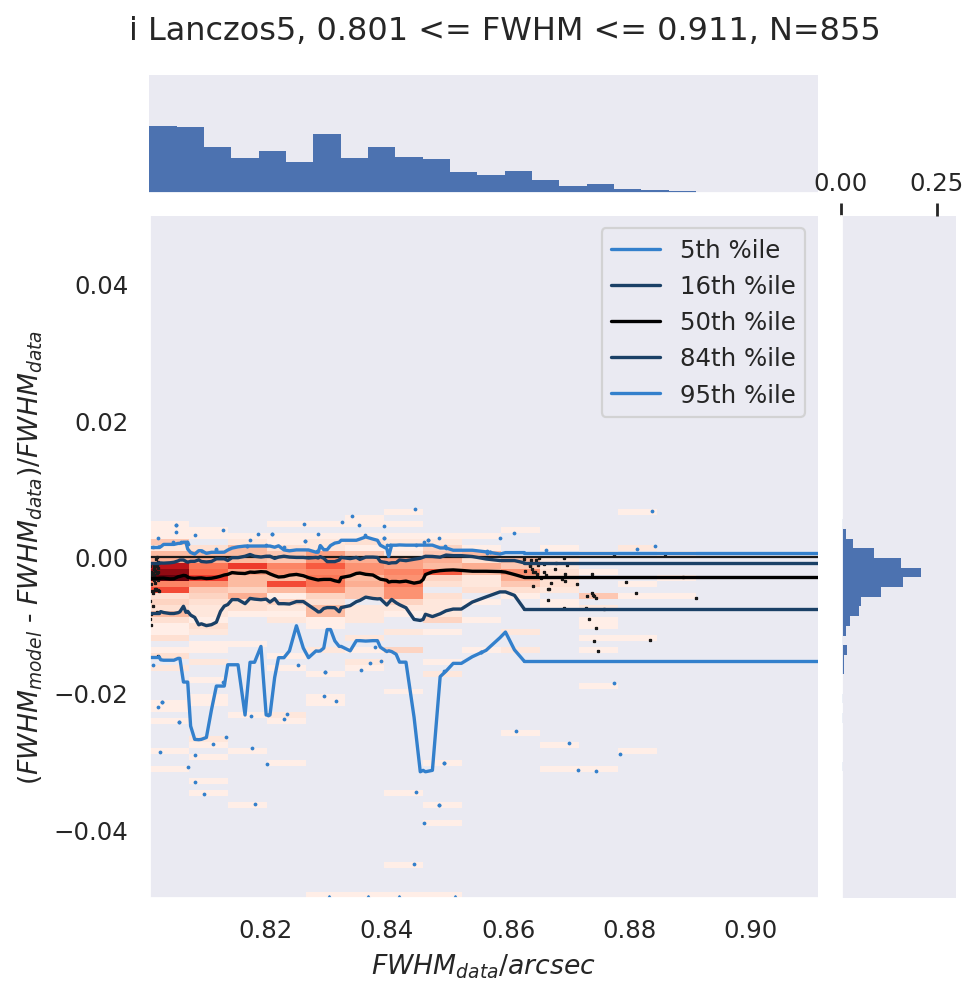

In [6]:
# Plot
doonlyoneplot = False
limsfrac = (-0.05, 0.05)
kwargs_plotjoint = dict(
    nbinspan = 8,
    densityplot=sns.histplot,
    cmap='Reds',
    limy=limsfrac,
    scatterleft=True,
    scatterright=True,
)
plot_patch = False
labelflux = 'log10(instFluxPsf)'
labelsizeresid = r'($FWHM_{model}$ - $FWHM_{data}$)/$FWHM_{data}$'
labelsize = r'$FWHM_{data}/arcsec$'
limxs = {band: x for band, x in zip(bands, ((0.6, 1.2), (0.7, 0.9), (0.7, 0.9),))}

for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        limx = limxs[band]
        x = np.clip(datum['starSize'], limx[0], limx[1])
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        title=f'{band} {typeofdata} PSF model residuals (N={len(x)})'
        print(title)
        plotjoint_running_percentiles(
            x, sizefrac, limx=limx, ndivisions=32,
            labelx=labelsize, labely=labelsizeresid, title=title,
            **kwargs_plotjoint
        )
        plt.show()
        
for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        condsizefrac = np.isfinite(sizefrac) & np.isfinite(datum['fluxPsf']) & (datum['starSize']<2)
        sizebins = np.sort(datum['starSize'][condsizefrac])[
            np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=4+1)), dtype=int)
        ]
        for idx in range(len(sizebins)*(not doonlyoneplot) + 2*doonlyoneplot-1):
            sizemin, sizemax = sizebins[idx:idx+2]
            cond = condsizefrac & (datum['starSize'] > sizemin) & (datum['starSize'] < sizemax)
            numpoints = np.sum(cond)
            title = f'{band} {typeofdata}, {sizemin:.3f} <= FWHM <= {sizemax:.3f}, N={numpoints}'
            if numpoints >= 100:    
                print(title)
                x = datum['starSize'][cond]
                y = sizefrac[cond]
                plotjoint_running_percentiles(
                    x, y, limx=(sizemin, sizemax), ndivisions=10,
                    labelx=labelsize, labely=labelsizeresid, title=title,
                    **kwargs_plotjoint
                )
                plt.show()
        if plot_patch:
            # TODO: Make sensible plots per patch
            for patch in patches:
                cond = (datum['file'] == patch) & condsizefrac
                grid = sns.jointplot(
                    np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1, 0.1],
                    stat_func=None, size=4, s=1, marginal_kws={'bins': 30},
                )
                grid.fig.suptitle(band)